In [3]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats


import pymysql
pymysql.install_as_MySQLdb()

from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists

In [2]:
df = pd.read_csv('insurance - insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Q1. Do smokers have higher insurance charges than non-smokers?

- 𝐻0 (Null Hypothesis): Smokers have equal insurance charges as non-smokers..
- 𝐻𝐴 (Alternative Hypothesis): There is a significant difference in insurance charges between smokers and non-smokers.

Based upon the Choosing the Right Hypothesis Test workflow from the LP:
- The appropriate test to perform would be:
    - Since we are measuring a numeric quantity (charges)
    - and we are comparing 2 groups (smokers and non-smokers).
    - We therefore want to perform a 2-sample t-test, A.K.A. an independent t-test.
- According the the work flow, the 2-sample T-Test has the following assumptions:
    - No significant outliers
    - Normality
    - Equal Variance

In [6]:
smokers_df = df.loc[ df['smoker']== 'yes', ['charges','smoker']]
non_smokers_df = df.loc[ df['smoker']== 'no', ['charges','smoker']]

In [7]:
smokers_group = smokers_df['charges']
non_smokers_group = non_smokers_df['charges']
display(smokers_group.head(), non_smokers_group.head())

0     16884.9240
11    27808.7251
14    39611.7577
19    36837.4670
23    37701.8768
Name: charges, dtype: float64

1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
5     3756.62160
Name: charges, dtype: float64

In [8]:
# Check for abs vlaue of z-scores that are > 3:
is_outlier_smokers = np.abs(stats.zscore(smokers_group)) > 3
print(f"There are {is_outlier_smokers.sum()} outliers in the discount group out of {len(smokers_group)})")

There are 0 outliers in the discount group out of 274)


In [9]:
# Check for abs vlaue of z-scores that are > 3:
is_outlier_non_smokers = np.abs(stats.zscore(non_smokers_group)) > 3
print(f"There are {is_outlier_non_smokers.sum()} outliers in the discount group out of {len(non_smokers_group)})")

There are 24 outliers in the discount group out of 1064)


In [10]:
# Remove outliers from discount_group
non_smokers_group = non_smokers_group.loc[~is_outlier_non_smokers]
non_smokers_group

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1040, dtype: float64

There are no outliers.

According to the workflow on the LP, since both groups have n > 15, we can safely ignore the assumption of normality.

In [11]:
result = stats.levene(smokers_group, non_smokers_group)
print(result)
print(result.pvalue<.05)

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)
True


- According to the documentation for stats.levene, the null hypothesis for the test is that both groups have equal variance. Since our p-value is less than .05 we reject that null hypothesis and conclude that our groups do NOT have equal variance.
- Since we did NOT meet the assumption of equal variance, we will run our stats.ttest_ind using equal_var=False. This will run a Welch's T-Test, which is designed to account for unequal variance.

In [13]:
result = stats.ttest_ind(smokers_group, non_smokers_group, equal_var=False)
print(result)
result.pvalue < .05

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)


True

Our Welch's T-Test returned a p-value < .05.

- We reject the null hypothesis and support the alternative hypothesis that there is a significant difference in charges for smokers versus non-smokers.
- In order to know if they are charged significantly MORE or LESS, we look at the actual means of our final groups.

In [14]:
# Barplot with no outliers:
plot_df = pd.concat([smokers_df.loc[~is_outlier_smokers], 
                     non_smokers_df.loc[~is_outlier_non_smokers]], axis=0)
plot_df

,charges,smoker
0,16884.9240,yes
11,27808.7251,yes
14,39611.7577,yes
19,36837.4670,yes
23,37701.8768,yes
...,...,...
1332,11411.6850,no
1333,10600.5483,no
1334,2205.9808,no
1335,1629.8335,no


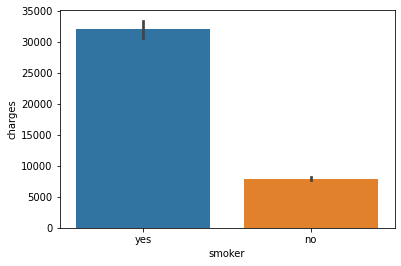

In [15]:
sns.barplot(data=plot_df, x='smoker',y='charges')

There are significantly higher charges for smokers versus non_smokers.

# Q2. Are men more likely to smoke than women?

- 𝐻0 (Null Hypothesis): Men and women are equally as likely to be smokers.
- 𝐻𝐴 (Alternative Hypothesis): Men are more likely to smoke than woman.

Based upon the Choosing the Right Hypothesis Test workflow from the LP:
- The appropriate test to perform would be:
    - Since we are comparing two nominal (categorical) variables
    - And the results are independent of each other.
    - We therefore want to perform a Chi-Square Test.
- According the the work flow, the Chi-Square Test has the following assumptions:
    - There are two categorical variables (ordinal or nominal)
    - Results are independent of each other.
    

We are comparing two categorical, nominal values (male/female and smoker/non-smoker), so the first criteria is fulfilled.

The outcomes are independent of each other.

In [20]:
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [21]:
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [22]:
print(p)
p<.05

0.006548143503580696


True

According to the p-value, we see that we can reject the null hypothesis and accept the alternative hypothesis, that there is indeed a correlation between gender and smoking. Men tend to be smokers more often than women.

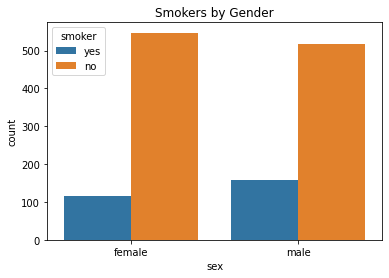

In [23]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Smokers by Gender");

# Q3. Do different regions have different charges, on average?

- 𝐻0 (Null Hypothesis): All regions have about the same charges.
- 𝐻𝐴 (Alternative Hypothesis): Regions vary significantly in charges.

Based upon the Choosing the Right Hypothesis Test workflow from the LP:
- The appropriate test to perform would be:
    - Since we are comparing numeric values (charges)
    - And comparing multiple variables (regions)
    - We therefore want to perform an ANOVA test.
- According the the work flow, the ANOVA Test has the following assumptions:
    - No significant outliers
    - Equal variance
    - Normality

In [27]:
# Separate groups:
groups = {}
for i in df['region'].unique():
    data = df.loc[df['region']==i,'charges'].copy()
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [29]:
# Test normality:
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [30]:
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


There is indeed more than 15 results in each group. It is normalized.

In [31]:
# Test equal variance:
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

We met the assumptions of equal variance.

In [32]:
# Perform hypothesis test:
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)

Based on this we see that there is indeed a significant difference in charges.

In [33]:
# Perform pairwise test:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

values = df['charges']
labels = df['region']

In [34]:
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


Based on the above results, we see there is only a significant difference between the regions of southeast and southwest. All the other regions are relatively similar.

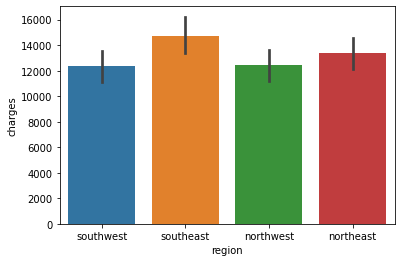

In [35]:
sns.barplot(data=df, x='region',y='charges');